<a href="https://colab.research.google.com/github/senju-sudharsan/DATA-SCIENCE-PROJECTS/blob/main/Enhanced_Anomaly_Detection_Comparison_with_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-17-e4f3a003a546>:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Class', group_keys=False).apply(
[I 2025-04-04 05:25:42,484] A new study created in memory with name: no-name-cdc437d4-64b4-4b56-8bba-67e1fa54cb62



Optimizing Isolation Forest...


[I 2025-04-04 05:25:42,822] Trial 0 finished with value: -0.004757590947527986 and parameters: {'n_estimators': 67, 'max_samples': 0.6481322483767467, 'contamination': 0.28780666070633326}. Best is trial 0 with value: -0.004757590947527986.
[I 2025-04-04 05:25:43,645] Trial 1 finished with value: -0.02997809656011194 and parameters: {'n_estimators': 134, 'max_samples': 0.6315490539462157, 'contamination': 0.09524428137932892}. Best is trial 0 with value: -0.004757590947527986.
[I 2025-04-04 05:25:44,300] Trial 2 finished with value: -0.13507092327587458 and parameters: {'n_estimators': 137, 'max_samples': 0.15074076281454032, 'contamination': 0.018422727418424337}. Best is trial 0 with value: -0.004757590947527986.
[I 2025-04-04 05:25:44,764] Trial 3 finished with value: -0.013593701997603408 and parameters: {'n_estimators': 77, 'max_samples': 0.5076361426191177, 'contamination': 0.19275314909846653}. Best is trial 0 with value: -0.004757590947527986.
[I 2025-04-04 05:25:45,680] Trial 


Optimizing One-Class SVM...


[I 2025-04-04 05:25:51,250] Trial 0 finished with value: -27.686884038308865 and parameters: {'nu': 0.15424808662539005, 'kernel': 'rbf'}. Best is trial 0 with value: -27.686884038308865.
[I 2025-04-04 05:25:52,130] Trial 1 finished with value: 5.7297905158490435e-05 and parameters: {'nu': 0.24059111738056554, 'kernel': 'linear'}. Best is trial 1 with value: 5.7297905158490435e-05.
[I 2025-04-04 05:25:53,016] Trial 2 finished with value: -11.235054778214515 and parameters: {'nu': 0.07680604235011386, 'kernel': 'rbf'}. Best is trial 1 with value: 5.7297905158490435e-05.
[I 2025-04-04 05:25:57,061] Trial 3 finished with value: -31.849612142804034 and parameters: {'nu': 0.2878074090569229, 'kernel': 'rbf'}. Best is trial 1 with value: 5.7297905158490435e-05.
[I 2025-04-04 05:26:00,370] Trial 4 finished with value: -34.028232955528644 and parameters: {'nu': 0.2615593940777389, 'kernel': 'rbf'}. Best is trial 1 with value: 5.7297905158490435e-05.
[I 2025-04-04 05:26:00,913] Trial 5 finished

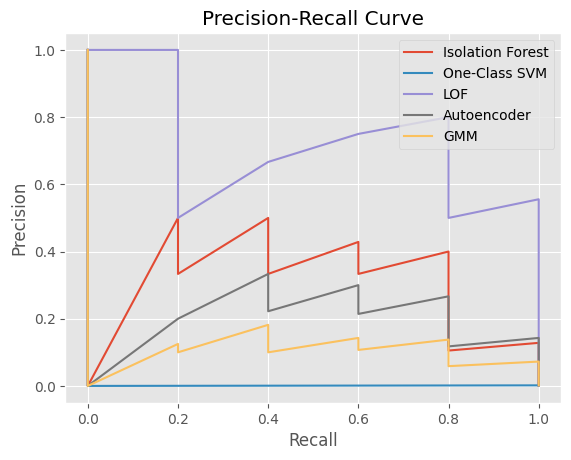

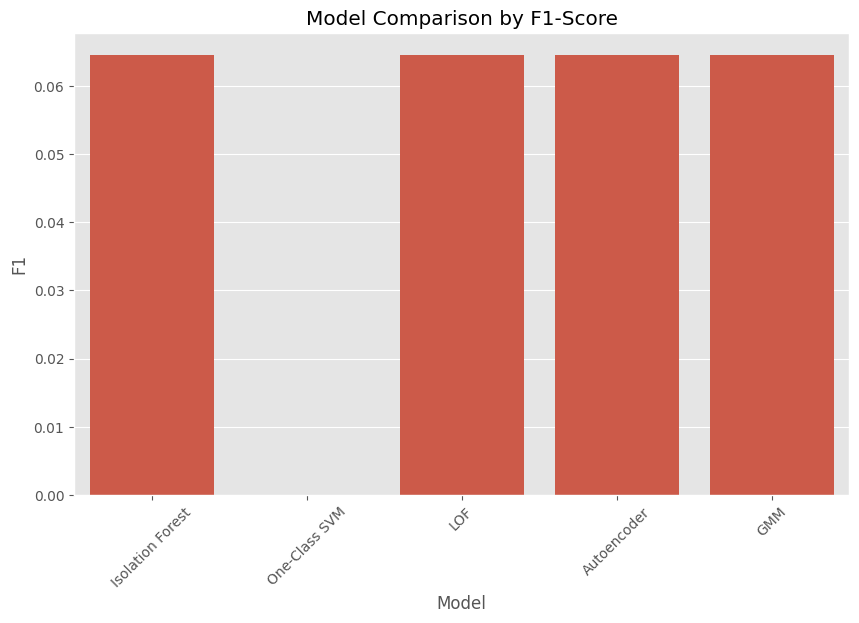

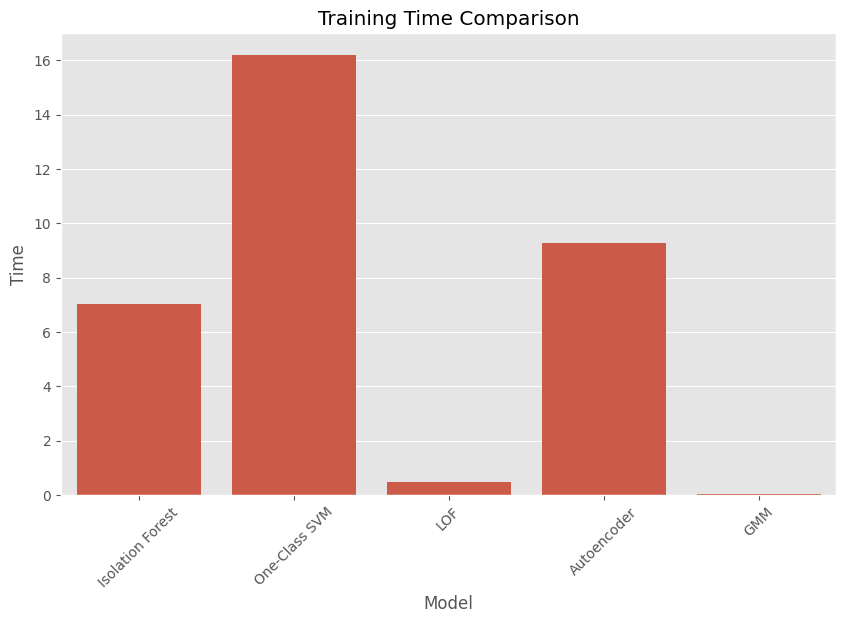


Final Results:


,Model,Precision,Recall,F1,AP,Time
0,Isolation Forest,0.033333,1.0,0.064516,0.391355,7.038760
2,LOF,0.033333,1.0,0.064516,0.754444,0.473401
3,Autoencoder,0.033333,1.0,0.064516,0.248571,9.260103
4,GMM,0.033333,1.0,0.064516,0.132014,0.056451
1,One-Class SVM,0.000000,0.0,0.000000,0.001009,16.191015


In [17]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna
import joblib
import time
import requests
import io

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.mixture import GaussianMixture
from pyod.models.auto_encoder import AutoEncoder

# Config
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.style.use('ggplot')

# 1. Data Loader
class ColabDataLoader:
    def __init__(self):
        self.creditcard_url = "https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv"

    def load_creditcard(self, sample_size=None):
        print("Downloading Credit Card Fraud dataset...")
        content = requests.get(self.creditcard_url).content
        df = pd.read_csv(io.StringIO(content.decode('utf-8')))

        if sample_size:
            # Stratified sampling to maintain class balance
            df = df.groupby('Class', group_keys=False).apply(
                lambda x: x.sample(int(sample_size * len(x) / len(df)), random_state=RANDOM_STATE)
            )

        X = df.drop('Class', axis=1).values
        y = df['Class'].values
        return X, y

# 2. Detector Class
class AnomalyDetector:
    def __init__(self):
        self.models = {
            'Isolation Forest': IsolationForest(random_state=RANDOM_STATE),
            'One-Class SVM': OneClassSVM(),
            'LOF': LocalOutlierFactor(novelty=True),
            'Autoencoder': AutoEncoder(verbose=0),
            'GMM': GaussianMixture(random_state=RANDOM_STATE)
        }

    def train(self, X_train, optimize=False):
        results = {}
        for name, model in self.models.items():
            start = time.time()

            if optimize and name in ['Isolation Forest', 'One-Class SVM']:
                print(f"\nOptimizing {name}...")
                best_params = self._optimize_model(name, X_train)
                model.set_params(**best_params)

            # Train the model
            if name == 'Autoencoder':
                model.fit(X_train)  # Let it use default internal epochs
            else:
                model.fit(X_train)

            results[name] = {
                'model': model,
                'train_time': time.time() - start
            }

        return results

    def _optimize_model(self, name, X_train):
        study = optuna.create_study(direction='maximize')

        def objective(trial):
            if name == 'Isolation Forest':
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                    'max_samples': trial.suggest_float('max_samples', 0.1, 1.0),
                    'contamination': trial.suggest_float('contamination', 0.01, 0.3)
                }
                model = IsolationForest(**params, random_state=RANDOM_STATE)
            else:
                params = {
                    'nu': trial.suggest_float('nu', 0.01, 0.3),
                    'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf'])
                }
                model = OneClassSVM(**params)

            model.fit(X_train)
            scores = -model.decision_function(X_train)
            return np.mean(scores)

        study.optimize(objective, n_trials=10)
        return study.best_params

    def evaluate(self, models, X_test, y_test):
        results = []

        for name, model_data in models.items():
            model = model_data['model']

            # Get scores
            if name in ['Isolation Forest', 'One-Class SVM']:
                scores = -model.decision_function(X_test)
            elif name == 'LOF':
                scores = -model.decision_function(X_test)
            elif name == 'Autoencoder':
                scores = model.decision_function(X_test)
            elif name == 'GMM':
                scores = -model.score_samples(X_test)

            threshold = np.percentile(scores, 95)
            y_pred = (scores > threshold).astype(int)

            report = classification_report(y_test, y_pred, output_dict=True)
            precision, recall, _ = precision_recall_curve(y_test, scores)
            ap = average_precision_score(y_test, scores)

            results.append({
                'Model': name,
                'Precision': report['1']['precision'],
                'Recall': report['1']['recall'],
                'F1': report['1']['f1-score'],
                'AP': ap,
                'Time': model_data['train_time']
            })

            plt.plot(recall, precision, label=name)

        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.legend()
        plt.show()

        return pd.DataFrame(results)

# 3. Visualizer
def plot_results(results_df):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=results_df, x='Model', y='F1')
    plt.title('Model Comparison by F1-Score')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.barplot(data=results_df, x='Model', y='Time')
    plt.title('Training Time Comparison')
    plt.xticks(rotation=45)
    plt.show()

# 4. Main Runner
def run_comparison(dataset='creditcard', sample_size=10000, optimize=False):
    loader = ColabDataLoader()
    X, y = loader.load_creditcard(sample_size)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
    )

    # Ensure length match
    assert len(X_train) == len(y_train)
    assert len(X_test) == len(y_test)

    detector = AnomalyDetector()
    trained = detector.train(X_train, optimize=optimize)
    results = detector.evaluate(trained, X_test, y_test)
    plot_results(results)
    return results

# 5. Run it
results = run_comparison(dataset='creditcard', sample_size=10000, optimize=True)

print("\nFinal Results:")
display(results.sort_values('F1', ascending=False))
